# General

Notebook for generating [photomosaics](https://en.wikipedia.org/wiki/Photographic_mosaic).

So what are those? Kind of pixellated high-res replicas of a given input image, formed by stitching together other images. Something like this but with square images (*image from Wikipedia, By The original uploader was J2thawiki at English Wikipedia.*)

![Example photomosaic](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Mosaicr_seagull.jpg/1280px-Mosaicr_seagull.jpg)

## How?

On a high level: for each small region in the input image (the image that is to be reconstructed), we calculate the average color, find the image with most similar average color and use it to represent that part of the input image. With a big and varying collection of images to use and each image being tiny part of the generated image, we should be able to produce fairly good photomosaics.

So we need a somewhat large collection of images. An input image is defined, and the code will kind of replicate that by forming a corresponding, high-resolution "pixellated" image using smaller images from the image collection as "pixels".

So at distance, the new image should ideally very much resemble the original input image. When zooming in, we should see that it is built using the images from the colllection.


In [12]:
# Imports
from PIL import Image, ExifTags
from pathlib import Path
from collections import defaultdict

import numpy as np
import math
import os
import json
import cv2

# Disable decompression bomb dos attack check:
# We will be working with very high-res images, and these is a safety mechanism in PIL that would block these ops unless we set:
Image.MAX_IMAGE_PIXELS = None

In [13]:
CLEAR_CACHE = False
SQUARE_SIZE_PX = 150

# The new pixellated image needs to be high-res to fit all those small images... it will take quite a bit disk space
RESIZE_INPUT_TO_MAXDIMS = (16500, 16500)

# CACHE FILE
# Stores image attributes so that we don't need to process these over and over again
CACHE_FILE = "./images_cache.json"

# Define folders for the original images and their cropped versions.
SOURCE_ORIGINALS_FOLDER = Path(r"C:\TEMP\photomosaic\original")
CROPPED_IMG_FOLDER = Path(r"C:\TEMP\photomosaic\cropped_square_imgs")

## Definitions

In [14]:
# FUNCS for IMG MANIPULATION
def resize_img(img, percentage, method=Image.ANTIALIAS):
    w, h = img.size
    print("Resizing to:", (round(w * percentage), round(h * percentage)))
    return img.resize((round(w * percentage), round(h * percentage)), method)


def resize_img_preserve_aspect(img, max_dims, resample=Image.BICUBIC):
    max_w, max_h = max_dims
    w, h = img.size
    
    ratio_w = float(max_w) / w
    ratio_h = float(max_h) / h
    
    min_ratio = min(ratio_w, ratio_h)
    
    return img.resize((round(min_ratio * w), round(min_ratio * h)), resample)


def rotatedRectWithMaxArea(w, h, angle):
  """
  Given a rectangle of size w x h that has been rotated by 'angle' (in
  radians), computes the width and height of the largest possible
  axis-aligned rectangle (maximal area) within the rotated rectangle.
  """
  if w <= 0 or h <= 0:
    return 0,0

  width_is_longer = w >= h
    
  side_long, side_short = (w,h) if width_is_longer else (h,w)

  # since the solutions for angle, -angle and 180-angle are all the same,
  # if suffices to look at the first quadrant and the absolute values of sin,cos:
  sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
  if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
    # half constrained case: two crop corners touch the longer side,
    #   the other two corners are on the mid-line parallel to the longer line
    x = 0.5*side_short
    wr,hr = (x/sin_a,x/cos_a) if width_is_longer else (x/cos_a,x/sin_a)
  else:
    # fully constrained case: crop touches all 4 sides
    cos_2a = cos_a*cos_a - sin_a*sin_a
    wr,hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a

  return wr, hr


def crop_input_image_to_evenly_match_square_size(input_img, square_size):
    """Input img is the PIL Image.
    Crop from the right and bottom so that the dims become integer multiple of the square_size
    """
    w, h = input_img.size
    w = w // square_size
    h = h // square_size
    
    return input_img.crop((0, 0, w*square_size, h*square_size))


# Crop image to square, with the size being the min(w,h)
# ~center crop could be the best?
def crop_to_square(img):
    """Takes PIL image, returns cropped PIL image"""
    w,h = img.size
    cropped_size = min(img.size)-1
    margin = round(0.5*(max(img.size) - min(img.size)))
    #print("Margin:", margin)
     
    if w >= h:
        left = margin
        upper = 0
        right = margin + cropped_size
        lower = cropped_size
    else:
        left = 0
        upper = margin
        right = cropped_size
        lower = margin + cropped_size
        
    #print(left, upper, right, lower)
    return img.crop((left, upper, right, lower))

In [15]:
# SOURCE IMAGE COLOR CALCULATIONS

# Divide source image to smaller squares, and calc the mean color
def avg_color(pixels):
    """Input as numpy array, RGB"""
    return pixels.reshape((-1, 3)).mean(axis=0)


def avg_quadrant_colors(pixels):
    """Input as numpy array, RGB"""
    mid_h = pixels.shape[0] // 2
    mid_w = pixels.shape[1] // 2
    
    avg_colors = [pixels[:mid_h, :mid_w, :].reshape((-1, 3)).mean(axis=0),
                  pixels[:mid_h, mid_w:, :].reshape((-1, 3)).mean(axis=0),
                  pixels[mid_h:, :mid_w, :].reshape((-1, 3)).mean(axis=0),
                  pixels[mid_h:, mid_w:, :].reshape((-1, 3)).mean(axis=0)]
    
    return avg_colors

def calc_color_dist(avg_color1, avg_color2) -> float:
    """Euclidean dist in RGB space. Inputs are numpy arrays"""
    return math.sqrt(((avg_color1 - avg_color2)**2).sum())
        

def calc_color_dist_4tile(avg_colors1, avg_colors2) -> float:
    """Euclidean dist in RGB space, calculated for each of the 4 image quadrants and combined by averaging"""
    assert len(avg_colors1) == 4
    assert len(avg_colors2) == 4
    
    return 0.25*sum(calc_color_dist(avgc1, avgc2) 
                    for avgc1, avgc2 in zip(avg_colors1, avg_colors2))


def find_img_with_closest_avg_color(color: np.array, cache: dict, method: str ="global"):
    """
    From given cache of image attributes, find the closest match with respect to the average color.
    
    color as numpy array with three values, RGB
    method: either global or 4tile: 
      - global refers to global average color, 
      - 4tile defines the average colors for the 4 quadrants of the image and uses them
    
    Returns best_match (image name) and its distance to 'color'
    """
    min_dist = 9999999
    best_match = None
    for img_name, avg_color in cache.items():
        if method == "global":
            d = calc_color_dist(color, avg_color[method][0])  # CHECK!!!
        elif method == "4tile":
            d = calc_color_dist_4tile(color, avg_color[method])
        
        if d < min_dist:
            min_dist = d
            best_match = img_name
            
    return best_match, min_dist
        

In [16]:
# PIXELLATED IMAGE GEN

def gen_pixellated_img_arr(img_arr, square_size=SQUARE_SIZE_PX):
    """Given image as numpy array, returns a new np array with the same shape, 
    but using avg color for each square of the given size.
    Right- and bottommost blocks are smaller, if needed"""
    pixellated_img_arr = np.zeros_like(img_arr)
    # upper left points
    for w in range(0, img_arr.shape[0], square_size):
        for h in range(0, img_arr.shape[1], square_size):
            color = avg_color(img_arr[w:w+square_size, h:h+square_size, :])
            #print(w, h, color)
            pixellated_img_arr[w:w+square_size, h:h+square_size, :] = color
            
    return pixellated_img_arr


def gen_pixellated_img(img_arr, square_size=SQUARE_SIZE_PX):
    """Returns the PIL image object instead of the numpy array"""
    pixellated_img_arr = gen_pixellated_img_arr(img_arr, square_size)
    return Image.fromarray(pixellated_img_arr.astype('uint8'), 'RGB')


In [17]:
# CACHE CONTROL

# When we create a square crop from a image file, calculate average color(s) [using different definitions]
# and store them to the cache dict (persisted on disk as json)
def save_img_cache(cache, cache_file):
    cache_to_persist = {fn: {method: [np_elem.tolist() for np_elem in li] 
                                for method, li in val_dict.items()} 
                                for fn, val_dict in cache.items()}  # CHECK!!!
    print("Saving image cache to:", cache_file)
    with open(cache_file, "w") as outfile:  
            json.dump(cache_to_persist, outfile)

            
def load_img_cache(cache_file) -> dict:
    if os.path.exists(cache_file):
        print("Found existing image cache, using it")
        with open(cache_file) as jsonfile:
            cache = json.load(jsonfile)
            cache = {fn: {method: [np.array(el) for el in li] for method, li in val_dict.items()} 
                         for fn, val_dict in cache.items()}
    else:
        print("Starting with empty cache")
        cache = {}
        # Maybe generate the empty cache file?
        save_img_cache(cache, cache_file)
        
    return cache
    
    
def purge_stale_cache(cache, cropped_img_path_obj):
    """Checks for missing files that are in cache. Removes them"""
    cropped_img_fns = set(f.name for f in cropped_img_path_obj.glob("*"))
    cache_fns = list(cache.keys())
    for cache_fn in cache_fns:
        if cache_fn not in cropped_img_fns:
            print("Purging cache for:", cache_fn)
            del cache[cache_fn]
    

In [18]:
def get_image_files_from_folder(path_object, img_exts=None):
    if img_exts is None:
        img_exts = ["jpg","gif","png","tga"]
    return [item for i in [path_object.glob('*.%s' % ext) for ext in img_exts] for item in i]


def get_new_originals(source_path_obj, cache_dict: dict) -> list:
    """Returns a list of filepaths, to those image files in source_path_obj that are not yet in the cache"""
    new_fps = []
    img_fps = get_image_files_from_folder(source_path_obj)
    
    for img_fp in img_fps:
        if img_fp.name not in cache_dict:
            new_fps.append(img_fp)
            
    return new_fps


def process_new_imgs(source_path_obj, cropped_path_obj, cache_dict, cache_file):
    """ Checks the source_path directory for new image files that are not yet in the cache.
    Processes them.
    Generates square crops and stores them.
    Adds average color info to the cache.
    Persists cache to disk.
    
    """
    new_fps = get_new_originals(source_path_obj, cache_dict)
    
    if len(new_fps) > 0:
        for img_fp in new_fps:
            print("Processing:", img_fp.name)
            gen_and_save_square_crop_img(img_fp, cropped_path_obj, images_cache=cache_dict)

        save_img_cache(cache_dict, cache_file)
        print("\nDONE")
    else:
        print("No new images found")


In [19]:
def open_and_rotate(img_fp):
    """ Tries to rotate based on Exif info (image metadata) about the image orientation"""
    im = Image.open(img_fp)
    
     # try to get exif info
    try:
        exif = { ExifTags.TAGS[k]: v for k, v in im._getexif().items() if k in ExifTags.TAGS }

        if exif["Orientation"] == 3:
            im=im.rotate(180, expand=True)
        elif exif["Orientation"] == 6:
            im=im.rotate(270, expand=True)
        elif exif["Orientation"] == 8:
            im=im.rotate(90, expand=True)
    except:
        print("Failed to get or process exif orientation info")

    return im


def gen_and_save_square_crop_img(img_fp, to_folder, images_cache, method="global"):
    """Aka prep image and generate cache entry"""
    filename = os.path.basename(img_fp)
    if filename in images_cache:
        print("Cached file, end processing")
        return None
    
    im = open_and_rotate(img_fp)
    im = im.convert("RGB")
    
    cropped_im = crop_to_square(im)
    cropped_im.save(CROPPED_IMG_FOLDER / filename)
    
    cropped_im_arr = np.array(cropped_im)
    
    avg_col_4tile = avg_quadrant_colors(cropped_im_arr)
    avg_col_global = avg_color(cropped_im_arr)
    
    images_cache[filename] = {"global": [avg_col_global], "4tile": avg_col_4tile}  # .tolist()
    

In [20]:
def get_best_matches_for_input_img_squares(input_img_arr, cropped_img_path_obj, square_size, cache, method="global"):
    assert input_img_arr.shape[0] % square_size == 0
    assert input_img_arr.shape[1] % square_size == 0
    
    subimgs = defaultdict(list)
    for h in range(0, input_img_arr.shape[0], square_size):
        for w in range(0, input_img_arr.shape[1], square_size):
            #print(w, h)
            #square_avg_color = avg_color(input_img_arr[h:h+square_size, w:w+square_size, :])
            if method == "global":
                square_avg_color = avg_color(input_img_arr[h:h+square_size, w:w+square_size, :])
            elif method == "4tile":
                square_avg_color = avg_quadrant_colors(input_img_arr[h:h+square_size, w:w+square_size, :])
            img_name, dist = find_img_with_closest_avg_color(square_avg_color, cache, method=method)
            subimgs[cropped_img_path_obj / img_name].append((w,h,square_size))
            #print(img_name, dist)
            
    return subimgs


def produce_photomosaic_img(subimgs_dict, input_size, sq_sz):
    """Input size like h x w x 3"""
    photomosaic_arr = np.zeros(input_size, dtype="uint8")  # h w
    print("Zeros of shape:", photomosaic_arr.shape)
    # assert
    
    for img_fp, pos_list in subimgs_dict.items():  # (w,h,sq_sz) 
    #for (w,h,sq_sz), img_fp in subimgs_list:
        #block_img_arr = np.array(Image.open(img_fp).convert("RGB").resize(size=(sq_sz, sq_sz)))  # h, w, rgb
        print(str(img_fp))
        block_img_arr = cv2.imread(str(img_fp))
        if block_img_arr is None:
            block_img_arr = np.array(Image.open(img_fp).convert("RGB").resize(size=(sq_sz, sq_sz)))[:,:,::-1]
        else:
            block_img_arr = cv2.resize(block_img_arr, (sq_sz, sq_sz), interpolation = cv2.INTER_CUBIC)
        for (w,h,sq_sz) in pos_list:
            print("Width:", w, " -- Height:", h)
            photomosaic_arr[h:h+sq_sz, w:w+sq_sz, 0:3] = block_img_arr  # swapped w <-> h in the axis order
                                 
    return photomosaic_arr

In [14]:
# %%timeit
# block_img_arr = cv2.imread(str(TEST_IMG))
# block_img_arr = cv2.resize(block_img_arr, (sq_sz, sq_sz), interpolation = cv2.INTER_CUBIC)


In [231]:
# %%timeit
# block_img_arr = np.array(Image.open(TEST_IMG).convert("RGB").resize(size=(sq_sz, sq_sz)))[:,:,::-1]  # nearest


399 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Main

In [24]:
# TODO: When cropping and saving, the rotation sometimes change. EXIF. Maybe OK now

# PIL can read the picture's metadata, but it does not write/copy metadata when you save an Image. 
# Consequently, your smart image viewer will not rotate the image as it did before.

# So it seems that PIL will autorotate those for presentation, but then downstreams apps are stripped off this info

In [17]:
# TODO: Automatically convert heic --> jpg and rem heic files (heics do not work with pillow)
#from subprocess import call
#call(["C:/TEMP/photomosaic/HeicFileConsole.exe", "jpg", "start"])  
# how to send the subsequent commands jpg+enter and start+enter?

# Now I used this manually

In [21]:
# LOAD CACHE OR START WITH AN EMPTY ONE

if CLEAR_CACHE:
    cache = {}
else:
    cache = load_img_cache(CACHE_FILE)
    
len(cache)

Found existing image cache, using it


567

In [36]:
# TODO: Create a cache object that knows its filepath and method to persist

In [37]:
# TODO
# Process that checks originals folder. Are there files that are not yet in the cache? New files, process...

# For that process, go thru all files, update cache and finally persist cache to disk

In [22]:
process_new_imgs(SOURCE_ORIGINALS_FOLDER, CROPPED_IMG_FOLDER, cache, CACHE_FILE)

No new images found


Procedure in a nutshell:
 - HOUSEKEEPING:
     - Read in the image cache, or init with new empty cache.
     - Go thru the cached file info, check that we do have the cropped square files for each. If not, remove from cache.
     - Check for possible new images in the collection, process them, add to cache.
 - GENERATE MOSAIC:
     - Get the input image, construct a high-res pixellated version of it by using the collection of images in cache. For each part of the input image, find the image from the collection that has most similar color. Stitch the square crop of that into the correspondig place
 
 

In [76]:
purge_stale_cache(cache, CROPPED_IMG_FOLDER)

(3264, 2448)
(16500, 12375)
Resizing to: (1650, 1238)


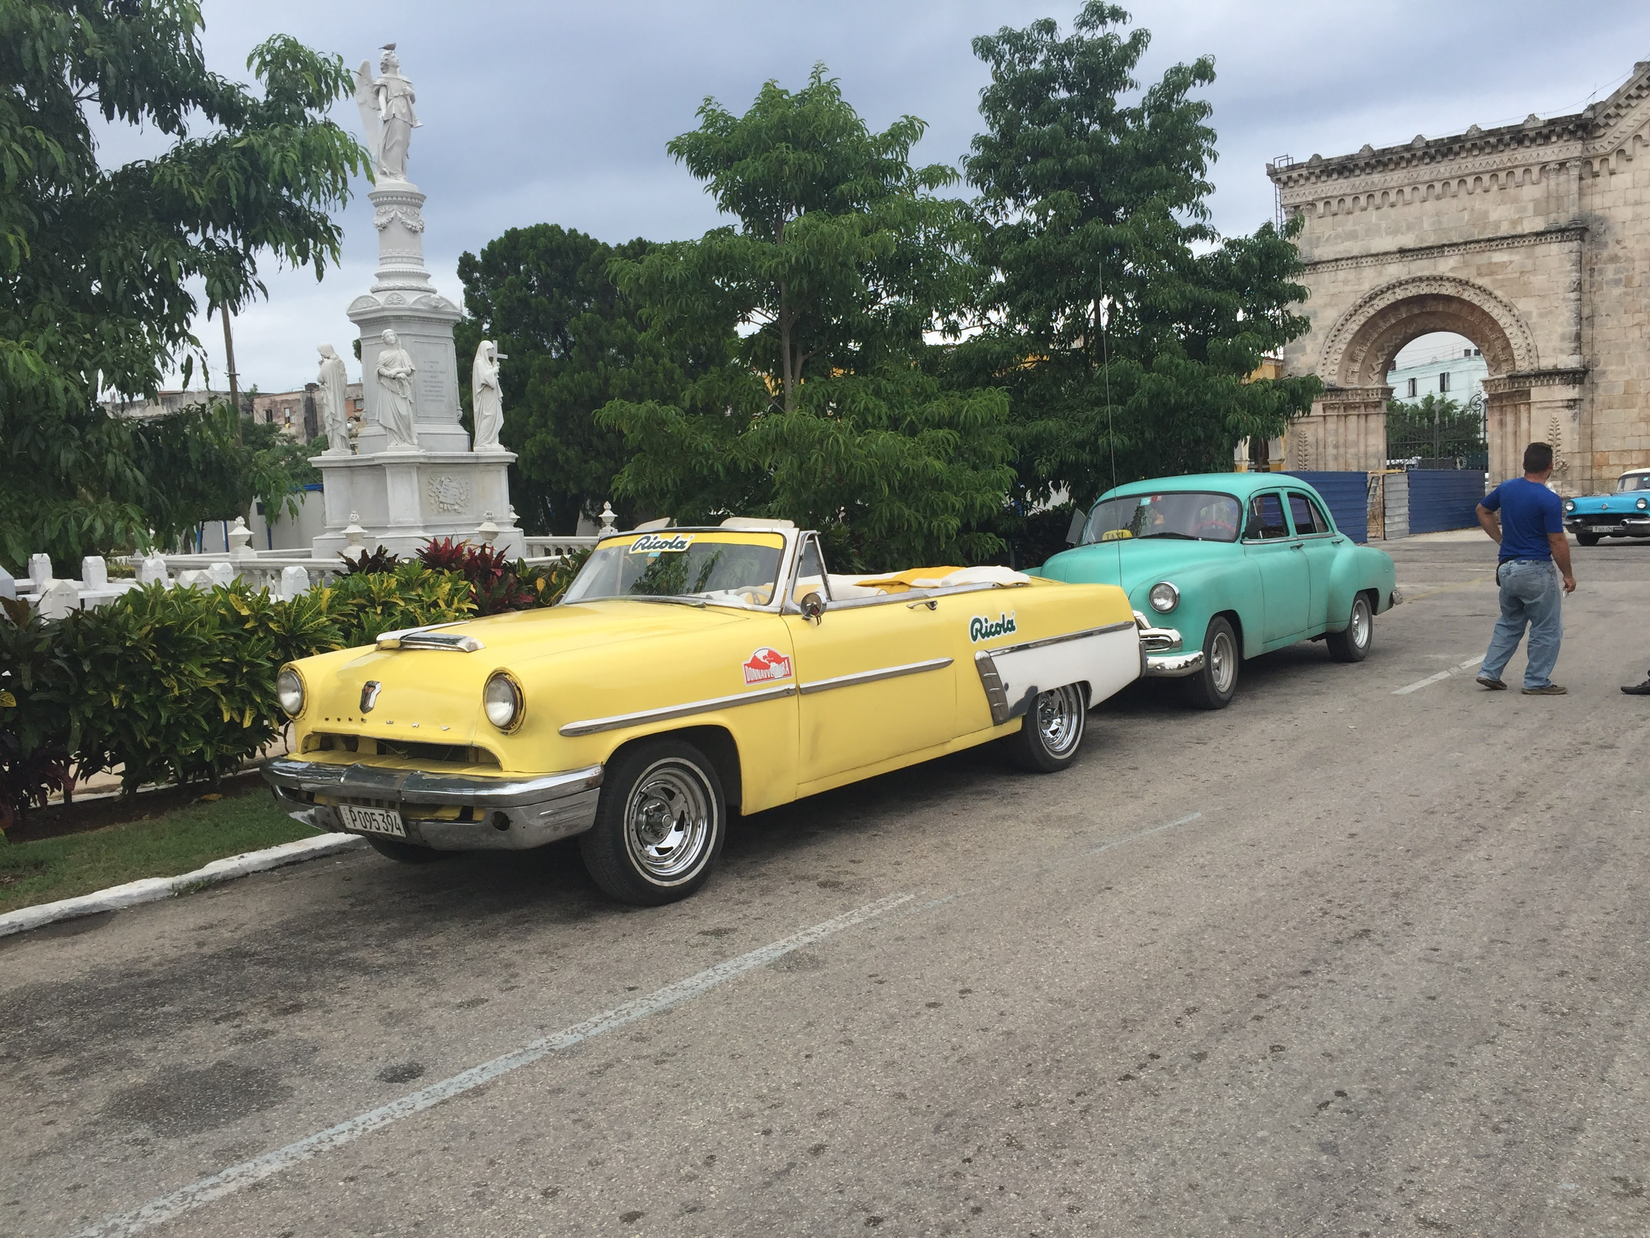

In [34]:
#RESIZE_INPUT_TO_MAXDIMS = (15000, 15000)

# Load the input image (to be replicated by a bunch of sample images)
#TEST_IMG = Path(r"C:\TEMP\photomosaic\original\IMG_5958.jpg")
#TEST_IMG = Path(r"C:\TEMP\photomosaic\original\2015-11-26 007.jpg")
TEST_IMG = Path(r"C:\TEMP\photomosaic\original\IMG_1393.jpg")

test_img = open_and_rotate(TEST_IMG)
print(test_img.size)
test_img = resize_img_preserve_aspect(img=test_img, max_dims=RESIZE_INPUT_TO_MAXDIMS)
print(test_img.size)

test_img = test_img.convert("RGB")

# Just to show the image
resize_img(test_img, 0.1)
    

In [35]:
#SQUARE_SIZE_PX = 200

print(test_img.size)
test_img = crop_input_image_to_evenly_match_square_size(test_img, SQUARE_SIZE_PX)
print(test_img.size)
test_img_arr = np.array(test_img, dtype="uint8")

proc_input_size = test_img_arr.shape

subimgs = get_best_matches_for_input_img_squares(test_img_arr, CROPPED_IMG_FOLDER, square_size=SQUARE_SIZE_PX, 
                                                 cache=cache, method="4tile")
#subimgs

(16500, 12375)
(16500, 12300)


In [36]:
# Producing the photomosaic can take several minutes...
# Currently done in memory - make sure you have enough RAM!
photomosaic_arr = produce_photomosaic_img(subimgs, proc_input_size, SQUARE_SIZE_PX)  # 4min
photomosaic_img = Image.fromarray(photomosaic_arr.astype('uint8')[...,::-1], 'RGB') 

print(photomosaic_img.size)
photomosaic_img.save(f"C:/TEMP/photomosaic_{TEST_IMG.name}.jpg")

Zeros of shape: (12300, 16500, 3)
C:\TEMP\photomosaic\cropped_square_imgs\IMG_4367.jpg
Width: 0  -- Height: 0
Width: 900  -- Height: 450
Width: 7650  -- Height: 900
Width: 7650  -- Height: 1050
Width: 7800  -- Height: 1050
Width: 8100  -- Height: 1050
Width: 7350  -- Height: 1200
Width: 7500  -- Height: 1200
Width: 8250  -- Height: 1200
Width: 8400  -- Height: 1200
Width: 3000  -- Height: 1350
Width: 6900  -- Height: 1350
Width: 8400  -- Height: 1350
Width: 2700  -- Height: 1500
Width: 2850  -- Height: 1500
Width: 8850  -- Height: 1950
Width: 11550  -- Height: 1950
Width: 8850  -- Height: 2100
Width: 9300  -- Height: 2100
Width: 9600  -- Height: 2100
Width: 7800  -- Height: 2250
Width: 8250  -- Height: 2250
Width: 9600  -- Height: 2250
Width: 11100  -- Height: 2250
Width: 7350  -- Height: 2400
Width: 7800  -- Height: 2400
Width: 8550  -- Height: 2400
Width: 1650  -- Height: 2550
Width: 6450  -- Height: 2550
Width: 6750  -- Height: 2550
Width: 14550  -- Height: 3150
Width: 13800  -- Hei

Width: 750  -- Height: 10050
Width: 1200  -- Height: 10050
Width: 1350  -- Height: 10050
Width: 1800  -- Height: 10050
Width: 900  -- Height: 10200
Width: 1050  -- Height: 10200
Width: 1350  -- Height: 10200
Width: 300  -- Height: 10350
Width: 600  -- Height: 10350
Width: 2400  -- Height: 10650
Width: 2100  -- Height: 10800
Width: 2400  -- Height: 10800
Width: 1350  -- Height: 10950
Width: 1500  -- Height: 10950
Width: 1650  -- Height: 10950
C:\TEMP\photomosaic\cropped_square_imgs\IMG_1056.jpg
Width: 1050  -- Height: 0
Width: 1350  -- Height: 0
Width: 300  -- Height: 150
Width: 1050  -- Height: 150
Width: 10800  -- Height: 450
Width: 10950  -- Height: 450
Width: 11100  -- Height: 450
Width: 10050  -- Height: 750
Width: 11700  -- Height: 750
Width: 11550  -- Height: 900
Width: 2850  -- Height: 1050
Width: 10050  -- Height: 1050
Width: 11400  -- Height: 1050
Width: 11700  -- Height: 1050
Width: 10200  -- Height: 1200
Width: 11400  -- Height: 1200
Width: 750  -- Height: 1350
Width: 2550  

Width: 7650  -- Height: 4200
Width: 7800  -- Height: 4200
Width: 7950  -- Height: 4200
Width: 8400  -- Height: 4200
Width: 10350  -- Height: 4200
Width: 10500  -- Height: 4200
Width: 12600  -- Height: 4200
Width: 13950  -- Height: 4200
Width: 14100  -- Height: 4200
Width: 14400  -- Height: 4200
Width: 14550  -- Height: 4200
Width: 900  -- Height: 4350
Width: 1050  -- Height: 4350
Width: 1200  -- Height: 4350
Width: 2100  -- Height: 4350
Width: 2550  -- Height: 4350
Width: 6900  -- Height: 4350
Width: 7050  -- Height: 4350
Width: 7350  -- Height: 4350
Width: 7500  -- Height: 4350
Width: 7950  -- Height: 4350
Width: 8100  -- Height: 4350
Width: 8250  -- Height: 4350
Width: 8400  -- Height: 4350
Width: 8550  -- Height: 4350
Width: 9150  -- Height: 4350
Width: 9300  -- Height: 4350
Width: 9750  -- Height: 4350
Width: 9900  -- Height: 4350
Width: 11100  -- Height: 4350
Width: 13950  -- Height: 4350
Width: 14100  -- Height: 4350
Width: 14400  -- Height: 4350
Width: 600  -- Height: 4500
Width

Width: 16350  -- Height: 450
Width: 2100  -- Height: 600
Width: 2250  -- Height: 600
Width: 3900  -- Height: 600
Width: 11400  -- Height: 600
Width: 11550  -- Height: 600
Width: 12150  -- Height: 600
Width: 12300  -- Height: 600
Width: 12450  -- Height: 600
Width: 12600  -- Height: 600
Width: 12750  -- Height: 600
Width: 12900  -- Height: 600
Width: 13050  -- Height: 600
Width: 13200  -- Height: 600
Width: 13350  -- Height: 600
Width: 13500  -- Height: 600
Width: 13650  -- Height: 600
Width: 14850  -- Height: 600
Width: 15000  -- Height: 600
Width: 15150  -- Height: 600
Width: 15300  -- Height: 600
Width: 15450  -- Height: 600
Width: 15600  -- Height: 600
Width: 15750  -- Height: 600
Width: 15900  -- Height: 600
Width: 16050  -- Height: 600
Width: 16200  -- Height: 600
Width: 3900  -- Height: 750
Width: 4050  -- Height: 750
Width: 4200  -- Height: 750
Width: 4350  -- Height: 750
Width: 4500  -- Height: 750
Width: 9600  -- Height: 750
Width: 12150  -- Height: 750
Width: 12300  -- Height

Width: 4350  -- Height: 4350
Width: 4500  -- Height: 4350
Width: 4800  -- Height: 4350
Width: 3900  -- Height: 4800
Width: 4050  -- Height: 4800
Width: 3900  -- Height: 4950
Width: 4050  -- Height: 4950
Width: 4950  -- Height: 4950
Width: 3900  -- Height: 5100
Width: 4050  -- Height: 5100
Width: 4950  -- Height: 5100
Width: 4050  -- Height: 5250
Width: 7350  -- Height: 5250
Width: 7500  -- Height: 5250
Width: 7650  -- Height: 5250
Width: 7800  -- Height: 5250
Width: 3150  -- Height: 5400
Width: 900  -- Height: 5550
Width: 1500  -- Height: 5550
Width: 2100  -- Height: 5550
Width: 7800  -- Height: 5550
Width: 900  -- Height: 5700
Width: 1800  -- Height: 5700
Width: 2100  -- Height: 5700
Width: 2850  -- Height: 5700
Width: 5850  -- Height: 5700
Width: 7800  -- Height: 5700
Width: 9150  -- Height: 5700
Width: 9300  -- Height: 5700
Width: 9450  -- Height: 5700
Width: 9600  -- Height: 5700
Width: 9750  -- Height: 5700
Width: 9900  -- Height: 5700
Width: 10050  -- Height: 5700
Width: 10200  -

Width: 8700  -- Height: 450
Width: 8850  -- Height: 450
Width: 9000  -- Height: 450
Width: 9150  -- Height: 450
Width: 9300  -- Height: 450
Width: 9450  -- Height: 450
Width: 9600  -- Height: 450
Width: 14100  -- Height: 450
Width: 14250  -- Height: 450
Width: 14400  -- Height: 450
Width: 14550  -- Height: 450
Width: 14700  -- Height: 450
Width: 14850  -- Height: 450
Width: 15000  -- Height: 450
Width: 3600  -- Height: 600
Width: 4050  -- Height: 600
Width: 4200  -- Height: 600
Width: 4350  -- Height: 600
Width: 4500  -- Height: 600
Width: 4650  -- Height: 600
Width: 4800  -- Height: 600
Width: 4950  -- Height: 600
Width: 5100  -- Height: 600
Width: 5250  -- Height: 600
Width: 5400  -- Height: 600
Width: 5550  -- Height: 600
Width: 5700  -- Height: 600
Width: 5850  -- Height: 600
Width: 6000  -- Height: 600
Width: 6150  -- Height: 600
Width: 6300  -- Height: 600
Width: 6450  -- Height: 600
Width: 6600  -- Height: 600
Width: 6750  -- Height: 600
Width: 6900  -- Height: 600
Width: 7050  

Width: 5550  -- Height: 2100
Width: 5700  -- Height: 2100
Width: 5850  -- Height: 2100
Width: 6000  -- Height: 2100
Width: 6150  -- Height: 2100
Width: 6300  -- Height: 2100
Width: 6450  -- Height: 2100
Width: 6600  -- Height: 2100
Width: 6750  -- Height: 2100
Width: 6900  -- Height: 2100
Width: 7050  -- Height: 2100
Width: 10050  -- Height: 2100
Width: 3450  -- Height: 2250
Width: 3600  -- Height: 2250
Width: 4200  -- Height: 2250
Width: 4350  -- Height: 2250
Width: 4500  -- Height: 2250
Width: 4650  -- Height: 2250
Width: 4800  -- Height: 2250
Width: 6000  -- Height: 2250
Width: 6150  -- Height: 2250
Width: 6300  -- Height: 2250
Width: 6450  -- Height: 2250
Width: 6600  -- Height: 2250
Width: 6750  -- Height: 2250
Width: 6900  -- Height: 2250
Width: 4200  -- Height: 2400
Width: 4350  -- Height: 2400
Width: 4500  -- Height: 2400
Width: 4650  -- Height: 2400
Width: 1950  -- Height: 3000
Width: 3600  -- Height: 3000
Width: 3900  -- Height: 3000
Width: 4050  -- Height: 3000
Width: 4350  

Width: 1500  -- Height: 150
Width: 1950  -- Height: 750
Width: 600  -- Height: 900
Width: 2250  -- Height: 900
Width: 750  -- Height: 1200
Width: 11850  -- Height: 1200
Width: 8550  -- Height: 1350
Width: 3000  -- Height: 2100
Width: 11100  -- Height: 2100
Width: 11700  -- Height: 2250
Width: 1800  -- Height: 2400
Width: 4650  -- Height: 2550
Width: 9450  -- Height: 2550
Width: 13950  -- Height: 4050
Width: 13050  -- Height: 4950
Width: 12750  -- Height: 5100
Width: 6750  -- Height: 5550
Width: 2850  -- Height: 8100
Width: 7050  -- Height: 8100
C:\TEMP\photomosaic\cropped_square_imgs\IMG_3115.jpg
Width: 1650  -- Height: 150
Width: 10050  -- Height: 300
Width: 2700  -- Height: 450
Width: 6750  -- Height: 1350
Width: 8850  -- Height: 1800
Width: 12900  -- Height: 2100
Width: 13050  -- Height: 4650
Width: 11400  -- Height: 5250
Width: 15150  -- Height: 5700
Width: 12600  -- Height: 6300
Width: 2100  -- Height: 9450
Width: 3900  -- Height: 10650
C:\TEMP\photomosaic\cropped_square_imgs\IMG_

Width: 1650  -- Height: 300
Width: 2700  -- Height: 600
Width: 3000  -- Height: 750
Width: 3150  -- Height: 750
Width: 8100  -- Height: 900
Width: 8250  -- Height: 900
Width: 3150  -- Height: 1350
Width: 3300  -- Height: 1500
Width: 3300  -- Height: 1650
Width: 2700  -- Height: 4350
Width: 6900  -- Height: 8100
Width: 3750  -- Height: 9600
Width: 900  -- Height: 9750
Width: 450  -- Height: 9900
Width: 1650  -- Height: 9900
Width: 450  -- Height: 10050
Width: 750  -- Height: 10200
Width: 1500  -- Height: 10200
Width: 150  -- Height: 10350
Width: 750  -- Height: 10350
Width: 150  -- Height: 10500
Width: 1050  -- Height: 10500
Width: 2250  -- Height: 10650
Width: 4050  -- Height: 10650
Width: 1950  -- Height: 10950
C:\TEMP\photomosaic\cropped_square_imgs\IMG_3057.jpg
Width: 1800  -- Height: 300
Width: 10350  -- Height: 300
Width: 4350  -- Height: 3150
Width: 12000  -- Height: 4950
Width: 12150  -- Height: 4950
Width: 11550  -- Height: 5100
Width: 11850  -- Height: 5100
Width: 10500  -- He

Width: 8100  -- Height: 4800
Width: 8700  -- Height: 4800
Width: 8850  -- Height: 4800
Width: 9450  -- Height: 4800
Width: 10350  -- Height: 4800
Width: 0  -- Height: 4950
Width: 1350  -- Height: 4950
Width: 1500  -- Height: 4950
Width: 1650  -- Height: 4950
Width: 6600  -- Height: 4950
Width: 6900  -- Height: 4950
Width: 7200  -- Height: 4950
Width: 7350  -- Height: 4950
Width: 9150  -- Height: 4950
Width: 9450  -- Height: 4950
Width: 9600  -- Height: 4950
Width: 0  -- Height: 5100
Width: 1500  -- Height: 5100
Width: 6750  -- Height: 5100
Width: 8700  -- Height: 5100
Width: 9000  -- Height: 5100
Width: 600  -- Height: 5250
Width: 750  -- Height: 5250
Width: 8700  -- Height: 5250
Width: 15750  -- Height: 5250
Width: 0  -- Height: 5400
Width: 450  -- Height: 5400
Width: 600  -- Height: 5400
Width: 750  -- Height: 5400
Width: 9750  -- Height: 5400
Width: 3600  -- Height: 5550
Width: 3750  -- Height: 5550
Width: 4350  -- Height: 5550
Width: 4500  -- Height: 5550
Width: 4800  -- Height: 55

Width: 16200  -- Height: 8400
Width: 16350  -- Height: 8400
Width: 9300  -- Height: 8550
Width: 9750  -- Height: 8550
Width: 9900  -- Height: 8550
Width: 10050  -- Height: 8550
Width: 10200  -- Height: 8550
Width: 10350  -- Height: 8550
Width: 10500  -- Height: 8550
Width: 10650  -- Height: 8550
Width: 10800  -- Height: 8550
Width: 10950  -- Height: 8550
Width: 11100  -- Height: 8550
Width: 11250  -- Height: 8550
Width: 11400  -- Height: 8550
Width: 11550  -- Height: 8550
Width: 12450  -- Height: 8550
Width: 13200  -- Height: 8550
Width: 13350  -- Height: 8550
Width: 13500  -- Height: 8550
Width: 13950  -- Height: 8550
Width: 14100  -- Height: 8550
Width: 14550  -- Height: 8550
Width: 14700  -- Height: 8550
Width: 15000  -- Height: 8550
Width: 15150  -- Height: 8550
Width: 15300  -- Height: 8550
Width: 16200  -- Height: 8550
Width: 9450  -- Height: 8700
Width: 9750  -- Height: 8700
Width: 9900  -- Height: 8700
Width: 10050  -- Height: 8700
Width: 10200  -- Height: 8700
Width: 10500  --

Width: 5400  -- Height: 10050
Width: 5550  -- Height: 10050
Width: 5700  -- Height: 10050
Width: 6750  -- Height: 10050
Width: 6900  -- Height: 10050
Width: 7050  -- Height: 10050
Width: 7200  -- Height: 10050
Width: 7350  -- Height: 10050
Width: 7500  -- Height: 10050
Width: 7950  -- Height: 10050
Width: 8100  -- Height: 10050
Width: 8250  -- Height: 10050
Width: 8550  -- Height: 10050
Width: 8700  -- Height: 10050
Width: 8850  -- Height: 10050
Width: 9000  -- Height: 10050
Width: 9150  -- Height: 10050
Width: 9450  -- Height: 10050
Width: 9600  -- Height: 10050
Width: 9750  -- Height: 10050
Width: 10500  -- Height: 10050
Width: 10650  -- Height: 10050
Width: 11250  -- Height: 10050
Width: 13050  -- Height: 10050
Width: 13200  -- Height: 10050
Width: 13350  -- Height: 10050
Width: 13500  -- Height: 10050
Width: 13650  -- Height: 10050
Width: 13800  -- Height: 10050
Width: 5250  -- Height: 10200
Width: 5400  -- Height: 10200
Width: 5550  -- Height: 10200
Width: 6750  -- Height: 10200
W

Width: 6000  -- Height: 11700
Width: 6150  -- Height: 11700
Width: 6300  -- Height: 11700
Width: 6450  -- Height: 11700
Width: 7050  -- Height: 11700
Width: 7200  -- Height: 11700
Width: 8100  -- Height: 11700
Width: 8700  -- Height: 11700
Width: 10200  -- Height: 11700
Width: 10350  -- Height: 11700
Width: 10650  -- Height: 11700
Width: 10950  -- Height: 11700
Width: 11100  -- Height: 11700
Width: 11250  -- Height: 11700
Width: 12000  -- Height: 11700
Width: 12450  -- Height: 11700
Width: 12750  -- Height: 11700
Width: 14550  -- Height: 11700
Width: 15600  -- Height: 11700
Width: 1500  -- Height: 11850
Width: 1650  -- Height: 11850
Width: 3600  -- Height: 11850
Width: 4050  -- Height: 11850
Width: 4350  -- Height: 11850
Width: 4500  -- Height: 11850
Width: 5100  -- Height: 11850
Width: 5250  -- Height: 11850
Width: 5700  -- Height: 11850
Width: 6150  -- Height: 11850
Width: 6450  -- Height: 11850
Width: 6600  -- Height: 11850
Width: 6750  -- Height: 11850
Width: 6900  -- Height: 11850

Width: 10350  -- Height: 600
Width: 7350  -- Height: 2250
C:\TEMP\photomosaic\cropped_square_imgs\IMG_9871.jpg
Width: 10500  -- Height: 600
Width: 11250  -- Height: 1200
Width: 13650  -- Height: 1500
Width: 9000  -- Height: 1800
Width: 14850  -- Height: 3900
Width: 3000  -- Height: 7650
C:\TEMP\photomosaic\cropped_square_imgs\IMG_9059.jpg
Width: 16350  -- Height: 600
Width: 8100  -- Height: 750
Width: 6600  -- Height: 5400
Width: 14850  -- Height: 6150
Width: 16350  -- Height: 6600
Width: 12450  -- Height: 10050
Width: 2100  -- Height: 10500
Width: 4050  -- Height: 10500
Width: 10050  -- Height: 10950
Width: 15000  -- Height: 11100
Width: 300  -- Height: 11400
Width: 2100  -- Height: 11400
Width: 600  -- Height: 11550
Width: 16050  -- Height: 11700
Width: 16050  -- Height: 11850
Width: 9600  -- Height: 12000
Width: 13200  -- Height: 12000
C:\TEMP\photomosaic\cropped_square_imgs\IMG_4843.jpg
Width: 150  -- Height: 750
Width: 10500  -- Height: 750
Width: 2100  -- Height: 1050
Width: 1650

Width: 900  -- Height: 900
Width: 7350  -- Height: 2100
Width: 2250  -- Height: 2250
Width: 4500  -- Height: 3750
Width: 4950  -- Height: 4050
Width: 4950  -- Height: 4350
C:\TEMP\photomosaic\cropped_square_imgs\IMG_4966.jpg
Width: 1650  -- Height: 900
Width: 1950  -- Height: 900
Width: 7800  -- Height: 1350
Width: 2400  -- Height: 1500
Width: 9900  -- Height: 1650
Width: 1800  -- Height: 2100
Width: 1950  -- Height: 2100
Width: 2100  -- Height: 2100
Width: 2400  -- Height: 2250
Width: 11100  -- Height: 2400
Width: 11700  -- Height: 2550
Width: 1200  -- Height: 2700
Width: 9150  -- Height: 2700
Width: 5400  -- Height: 3300
Width: 5550  -- Height: 3300
Width: 7650  -- Height: 3600
Width: 6150  -- Height: 3900
Width: 1350  -- Height: 4650
Width: 10650  -- Height: 4800
Width: 5100  -- Height: 4950
Width: 15000  -- Height: 4950
Width: 14550  -- Height: 5100
Width: 15000  -- Height: 5100
Width: 15450  -- Height: 5100
Width: 12450  -- Height: 5250
Width: 12600  -- Height: 5250
Width: 15150  

Width: 15900  -- Height: 1050
Width: 1350  -- Height: 3300
Width: 12750  -- Height: 3600
Width: 13650  -- Height: 4800
Width: 15600  -- Height: 5400
Width: 2400  -- Height: 5850
Width: 2700  -- Height: 9900
C:\TEMP\photomosaic\cropped_square_imgs\IMG_1663.jpg
Width: 16050  -- Height: 1050
Width: 5100  -- Height: 7050
C:\TEMP\photomosaic\cropped_square_imgs\IMG_9455.jpg
Width: 16200  -- Height: 1050
Width: 16050  -- Height: 1500
Width: 14100  -- Height: 1800
Width: 14400  -- Height: 1800
Width: 15900  -- Height: 2850
Width: 15900  -- Height: 4050
Width: 16050  -- Height: 4800
Width: 12000  -- Height: 7200
Width: 11850  -- Height: 7350
Width: 12000  -- Height: 7350
Width: 11400  -- Height: 7500
Width: 9450  -- Height: 8250
Width: 8850  -- Height: 8400
Width: 7950  -- Height: 8850
Width: 6750  -- Height: 9150
Width: 6900  -- Height: 9150
Width: 1050  -- Height: 9300
Width: 2850  -- Height: 10200
Width: 11250  -- Height: 10200
Width: 14700  -- Height: 10350
Width: 6600  -- Height: 10500
Wi

Width: 15000  -- Height: 1200
Width: 13350  -- Height: 1500
Width: 10650  -- Height: 6750
Width: 3150  -- Height: 8400
C:\TEMP\photomosaic\cropped_square_imgs\IMG_5286.jpg
Width: 15150  -- Height: 1200
C:\TEMP\photomosaic\cropped_square_imgs\IMG_8915.jpg
Width: 16350  -- Height: 1200
Width: 16050  -- Height: 1650
Width: 13200  -- Height: 1800
Width: 14850  -- Height: 1800
Width: 15000  -- Height: 1800
Width: 15900  -- Height: 1800
Width: 15600  -- Height: 1950
Width: 13500  -- Height: 2100
Width: 15150  -- Height: 2100
Width: 16050  -- Height: 2100
Width: 14400  -- Height: 2250
Width: 13050  -- Height: 2400
Width: 13200  -- Height: 2700
Width: 14700  -- Height: 2700
Width: 13050  -- Height: 2850
Width: 16050  -- Height: 2850
Width: 16350  -- Height: 2850
Width: 14850  -- Height: 3000
Width: 15000  -- Height: 3150
Width: 16050  -- Height: 3150
Width: 12900  -- Height: 3600
Width: 13050  -- Height: 3600
Width: 16050  -- Height: 3600
Width: 3600  -- Height: 3900
Width: 3600  -- Height: 40

Width: 9000  -- Height: 8700
Width: 9150  -- Height: 8700
Width: 9300  -- Height: 8700
Width: 9600  -- Height: 8700
Width: 10350  -- Height: 8700
Width: 13050  -- Height: 8700
Width: 13650  -- Height: 8700
Width: 14100  -- Height: 8700
Width: 14550  -- Height: 8700
Width: 15000  -- Height: 8700
Width: 15300  -- Height: 8700
Width: 15450  -- Height: 8700
Width: 15600  -- Height: 8700
Width: 15750  -- Height: 8700
Width: 16350  -- Height: 8700
Width: 8550  -- Height: 8850
Width: 8700  -- Height: 8850
Width: 10950  -- Height: 8850
Width: 13050  -- Height: 8850
Width: 13350  -- Height: 8850
Width: 13800  -- Height: 8850
Width: 14100  -- Height: 8850
Width: 15000  -- Height: 8850
Width: 15300  -- Height: 8850
Width: 15750  -- Height: 8850
Width: 15900  -- Height: 8850
Width: 16200  -- Height: 8850
Width: 16350  -- Height: 8850
Width: 7500  -- Height: 9000
Width: 7650  -- Height: 9000
Width: 7800  -- Height: 9000
Width: 7950  -- Height: 9000
Width: 8100  -- Height: 9000
Width: 8250  -- Heigh

Width: 11250  -- Height: 10350
Width: 11400  -- Height: 10350
Width: 11550  -- Height: 10350
Width: 11700  -- Height: 10350
Width: 11850  -- Height: 10350
Width: 12000  -- Height: 10350
Width: 12150  -- Height: 10350
Width: 12300  -- Height: 10350
Width: 13500  -- Height: 10350
Width: 13650  -- Height: 10350
Width: 13950  -- Height: 10350
Width: 14100  -- Height: 10350
Width: 14250  -- Height: 10350
Width: 14400  -- Height: 10350
Width: 14550  -- Height: 10350
Width: 15150  -- Height: 10350
Width: 15300  -- Height: 10350
Width: 15450  -- Height: 10350
Width: 15600  -- Height: 10350
Width: 15750  -- Height: 10350
Width: 15900  -- Height: 10350
Width: 16200  -- Height: 10350
Width: 16350  -- Height: 10350
Width: 3150  -- Height: 10500
Width: 3300  -- Height: 10500
Width: 3450  -- Height: 10500
Width: 3600  -- Height: 10500
Width: 3750  -- Height: 10500
Width: 3900  -- Height: 10500
Width: 4200  -- Height: 10500
Width: 4350  -- Height: 10500
Width: 5850  -- Height: 10500
Width: 6000  -- H

Width: 3450  -- Height: 11400
Width: 3750  -- Height: 11400
Width: 3900  -- Height: 11400
Width: 4050  -- Height: 11400
Width: 4350  -- Height: 11400
Width: 4650  -- Height: 11400
Width: 4800  -- Height: 11400
Width: 5100  -- Height: 11400
Width: 5250  -- Height: 11400
Width: 5700  -- Height: 11400
Width: 5850  -- Height: 11400
Width: 7800  -- Height: 11400
Width: 7950  -- Height: 11400
Width: 8250  -- Height: 11400
Width: 8400  -- Height: 11400
Width: 8550  -- Height: 11400
Width: 8700  -- Height: 11400
Width: 8850  -- Height: 11400
Width: 9000  -- Height: 11400
Width: 9150  -- Height: 11400
Width: 9300  -- Height: 11400
Width: 9450  -- Height: 11400
Width: 9900  -- Height: 11400
Width: 10200  -- Height: 11400
Width: 10350  -- Height: 11400
Width: 10650  -- Height: 11400
Width: 10800  -- Height: 11400
Width: 10950  -- Height: 11400
Width: 11100  -- Height: 11400
Width: 11400  -- Height: 11400
Width: 11550  -- Height: 11400
Width: 11700  -- Height: 11400
Width: 11850  -- Height: 11400


Width: 16200  -- Height: 12150
C:\TEMP\photomosaic\cropped_square_imgs\IMG_4529.jpg
Width: 16350  -- Height: 1350
Width: 15900  -- Height: 3150
Width: 15900  -- Height: 3600
Width: 15000  -- Height: 4200
Width: 7650  -- Height: 11250
C:\TEMP\photomosaic\cropped_square_imgs\2015-11-27 034.jpg
Width: 1500  -- Height: 1500
Width: 13050  -- Height: 1500
Width: 4950  -- Height: 2250
C:\TEMP\photomosaic\cropped_square_imgs\IMG_4385.jpg
Width: 6750  -- Height: 1500
Width: 2100  -- Height: 2250
Width: 14100  -- Height: 5250
C:\TEMP\photomosaic\cropped_square_imgs\IMG_0191.jpg
Width: 14550  -- Height: 1500
Width: 13650  -- Height: 1650
Width: 13800  -- Height: 2850
Width: 15450  -- Height: 3750
Width: 15450  -- Height: 6900
C:\TEMP\photomosaic\cropped_square_imgs\IMG_9249.jpg
Width: 14850  -- Height: 1500
Width: 13950  -- Height: 1650
Width: 14100  -- Height: 1650
Width: 15600  -- Height: 1650
Width: 12900  -- Height: 1800
Width: 14550  -- Height: 1800
Width: 3150  -- Height: 1950
Width: 13200 

Width: 1050  -- Height: 1650
C:\TEMP\photomosaic\cropped_square_imgs\Kål13.jpg
Width: 3600  -- Height: 1650
Width: 2250  -- Height: 3750
Width: 7950  -- Height: 5400
Width: 6900  -- Height: 8400
C:\TEMP\photomosaic\cropped_square_imgs\IMG_1434.jpg
Width: 10650  -- Height: 1650
Width: 10800  -- Height: 1650
Width: 8100  -- Height: 1800
Width: 1200  -- Height: 1950
Width: 8100  -- Height: 1950
Width: 750  -- Height: 2100
Width: 900  -- Height: 2100
Width: 300  -- Height: 2250
Width: 10950  -- Height: 2400
Width: 8850  -- Height: 2550
Width: 10050  -- Height: 2550
Width: 10350  -- Height: 2550
Width: 10500  -- Height: 2550
Width: 12600  -- Height: 2550
Width: 450  -- Height: 2700
Width: 600  -- Height: 2700
Width: 5550  -- Height: 2700
Width: 10200  -- Height: 2700
Width: 10800  -- Height: 2700
Width: 12300  -- Height: 2700
Width: 12600  -- Height: 2700
Width: 150  -- Height: 2850
Width: 750  -- Height: 2850
Width: 7950  -- Height: 2850
Width: 10050  -- Height: 2850
Width: 10650  -- Heig

Width: 1500  -- Height: 7350
Width: 3150  -- Height: 7350
Width: 7200  -- Height: 7350
Width: 10200  -- Height: 7350
Width: 1800  -- Height: 7500
Width: 1950  -- Height: 7500
Width: 2100  -- Height: 7500
Width: 2250  -- Height: 7500
Width: 2550  -- Height: 7650
Width: 6000  -- Height: 7650
Width: 9000  -- Height: 7650
Width: 300  -- Height: 7800
Width: 1650  -- Height: 7800
Width: 1800  -- Height: 7800
Width: 2850  -- Height: 7800
Width: 6000  -- Height: 7800
Width: 6150  -- Height: 7800
Width: 1050  -- Height: 7950
Width: 4050  -- Height: 7950
Width: 4200  -- Height: 7950
Width: 6000  -- Height: 7950
Width: 7200  -- Height: 7950
Width: 4950  -- Height: 8100
Width: 6000  -- Height: 8100
Width: 7500  -- Height: 8100
Width: 0  -- Height: 8250
Width: 5850  -- Height: 8250
Width: 6000  -- Height: 8250
Width: 4200  -- Height: 8400
Width: 4350  -- Height: 8400
Width: 4500  -- Height: 8400
Width: 4650  -- Height: 8400
Width: 4800  -- Height: 8400
Width: 4950  -- Height: 8400
Width: 5100  -- H

Width: 14700  -- Height: 1650
C:\TEMP\photomosaic\cropped_square_imgs\IMG_9557.jpg
Width: 14850  -- Height: 1650
Width: 13200  -- Height: 2550
Width: 3450  -- Height: 4050
Width: 15750  -- Height: 4050
Width: 12900  -- Height: 4350
Width: 13050  -- Height: 4350
Width: 15750  -- Height: 4350
Width: 13050  -- Height: 4500
Width: 15750  -- Height: 4650
Width: 14550  -- Height: 6750
Width: 12150  -- Height: 7200
Width: 11700  -- Height: 7350
Width: 10950  -- Height: 7650
Width: 11100  -- Height: 7650
Width: 10650  -- Height: 7800
Width: 10350  -- Height: 7950
Width: 9750  -- Height: 8100
Width: 9900  -- Height: 8100
Width: 10350  -- Height: 8100
Width: 9000  -- Height: 8400
Width: 9300  -- Height: 8400
Width: 7800  -- Height: 8850
Width: 1800  -- Height: 9150
Width: 7200  -- Height: 9150
Width: 16350  -- Height: 9150
Width: 1500  -- Height: 9300
Width: 1650  -- Height: 9300
Width: 300  -- Height: 9450
Width: 1050  -- Height: 9450
Width: 1200  -- Height: 9450
Width: 5700  -- Height: 9450
Wi

Width: 3000  -- Height: 1950
C:\TEMP\photomosaic\cropped_square_imgs\IMG_3064.jpg
Width: 9300  -- Height: 1950
Width: 9450  -- Height: 1950
Width: 7050  -- Height: 2250
C:\TEMP\photomosaic\cropped_square_imgs\IMG_0242.jpg
Width: 11100  -- Height: 1950
Width: 10200  -- Height: 2250
Width: 8550  -- Height: 2550
Width: 9150  -- Height: 3150
Width: 7800  -- Height: 3900
Width: 6150  -- Height: 4200
Width: 10200  -- Height: 4950
Width: 10650  -- Height: 5100
Width: 5250  -- Height: 5700
Width: 6900  -- Height: 7650
Width: 2700  -- Height: 7800
Width: 7050  -- Height: 7950
C:\TEMP\photomosaic\cropped_square_imgs\IMG_5151.jpg
Width: 11850  -- Height: 1950
Width: 2400  -- Height: 5100
Width: 13200  -- Height: 5250
C:\TEMP\photomosaic\cropped_square_imgs\Kål11.jpg
Width: 13050  -- Height: 1950
Width: 12750  -- Height: 4500
Width: 15600  -- Height: 10050
C:\TEMP\photomosaic\cropped_square_imgs\IMG_9321.jpg
Width: 13500  -- Height: 1950
Width: 13800  -- Height: 1950
Width: 16050  -- Height: 2250

C:\TEMP\photomosaic\cropped_square_imgs\IMG_2618.jpg
Width: 12000  -- Height: 2550
Width: 12900  -- Height: 3150
Width: 14250  -- Height: 4050
Width: 3300  -- Height: 7800
Width: 3600  -- Height: 7800
Width: 6750  -- Height: 8100
Width: 0  -- Height: 9300
C:\TEMP\photomosaic\cropped_square_imgs\IMG_5638.jpg
Width: 13500  -- Height: 2550
Width: 13500  -- Height: 3600
Width: 15750  -- Height: 4200
Width: 12750  -- Height: 4350
Width: 10200  -- Height: 7950
Width: 9300  -- Height: 8250
Width: 8700  -- Height: 8400
Width: 8550  -- Height: 8550
Width: 8400  -- Height: 8850
Width: 7200  -- Height: 9000
Width: 7350  -- Height: 9000
Width: 1500  -- Height: 9150
Width: 900  -- Height: 9300
Width: 450  -- Height: 9450
Width: 3300  -- Height: 10050
Width: 10050  -- Height: 11400
C:\TEMP\photomosaic\cropped_square_imgs\IMG_5240.jpg
Width: 15750  -- Height: 2550
Width: 13650  -- Height: 3600
Width: 13500  -- Height: 3900
Width: 13650  -- Height: 4950
Width: 8100  -- Height: 5550
Width: 3150  -- Hei

Width: 14250  -- Height: 2700
Width: 750  -- Height: 7800
C:\TEMP\photomosaic\cropped_square_imgs\IMG_8388.jpg
Width: 14850  -- Height: 2700
Width: 15000  -- Height: 3000
Width: 12600  -- Height: 3600
Width: 2850  -- Height: 4200
Width: 13050  -- Height: 4200
Width: 13200  -- Height: 4200
Width: 15150  -- Height: 4200
Width: 15000  -- Height: 4350
Width: 16200  -- Height: 4500
Width: 8700  -- Height: 5700
Width: 5550  -- Height: 6000
Width: 9300  -- Height: 6000
Width: 9900  -- Height: 6300
Width: 9450  -- Height: 6600
Width: 8850  -- Height: 6750
Width: 9000  -- Height: 6750
Width: 8100  -- Height: 6900
Width: 8250  -- Height: 6900
Width: 3000  -- Height: 7050
Width: 3600  -- Height: 7050
Width: 7200  -- Height: 7050
Width: 7350  -- Height: 7050
Width: 9600  -- Height: 7050
Width: 5400  -- Height: 7200
Width: 5100  -- Height: 7350
Width: 5700  -- Height: 7350
Width: 5850  -- Height: 7350
Width: 7950  -- Height: 7350
Width: 8100  -- Height: 7350
Width: 8250  -- Height: 7350
Width: 8550

Width: 4800  -- Height: 3300
Width: 7800  -- Height: 5100
Width: 6150  -- Height: 5250
C:\TEMP\photomosaic\cropped_square_imgs\IMG_6854.jpg
Width: 7350  -- Height: 3300
C:\TEMP\photomosaic\cropped_square_imgs\IMG_2172.jpg
Width: 7500  -- Height: 3300
Width: 750  -- Height: 7950
C:\TEMP\photomosaic\cropped_square_imgs\IMG_0358.jpg
Width: 9750  -- Height: 3300
Width: 4950  -- Height: 4200
Width: 11250  -- Height: 6750
C:\TEMP\photomosaic\cropped_square_imgs\IMG_4901.jpg
Width: 10200  -- Height: 3300
Width: 1200  -- Height: 7650
C:\TEMP\photomosaic\cropped_square_imgs\IMG_2664.jpg
Width: 13500  -- Height: 3300
Width: 4950  -- Height: 3600
Width: 15000  -- Height: 3750
Width: 13800  -- Height: 4050
Width: 13800  -- Height: 4200
Width: 12450  -- Height: 4500
Width: 15150  -- Height: 4650
C:\TEMP\photomosaic\cropped_square_imgs\IMG_2839.jpg
Width: 14850  -- Height: 3300
Width: 14850  -- Height: 3450
Width: 4350  -- Height: 5850
Width: 5100  -- Height: 6900
C:\TEMP\photomosaic\cropped_square_

Width: 14700  -- Height: 4350
Width: 3900  -- Height: 6000
C:\TEMP\photomosaic\cropped_square_imgs\IMG_6244.jpg
Width: 15450  -- Height: 4350
C:\TEMP\photomosaic\cropped_square_imgs\IMG_1390.jpg
Width: 4950  -- Height: 4500
Width: 11700  -- Height: 6300
Width: 2550  -- Height: 8550
C:\TEMP\photomosaic\cropped_square_imgs\IMG_6133.jpg
Width: 15900  -- Height: 4500
Width: 15900  -- Height: 4650
C:\TEMP\photomosaic\cropped_square_imgs\IMG_5081.jpg
Width: 16350  -- Height: 4500
Width: 8550  -- Height: 6750
Width: 7650  -- Height: 6900
C:\TEMP\photomosaic\cropped_square_imgs\IMG_0248.jpg
Width: 3150  -- Height: 4650
Width: 1950  -- Height: 5250
C:\TEMP\photomosaic\cropped_square_imgs\IMG_4433.jpg
Width: 11850  -- Height: 4650
Width: 12000  -- Height: 4650
Width: 11100  -- Height: 4800
Width: 13050  -- Height: 5250
Width: 10650  -- Height: 5400
Width: 15000  -- Height: 5550
C:\TEMP\photomosaic\cropped_square_imgs\IMG_1892.jpg
Width: 12150  -- Height: 4650
C:\TEMP\photomosaic\cropped_square_i

Width: 9000  -- Height: 5700
Width: 7950  -- Height: 5850
Width: 7650  -- Height: 6450
Width: 4950  -- Height: 6600
Width: 9000  -- Height: 6600
Width: 9150  -- Height: 6600
Width: 3000  -- Height: 6750
Width: 8100  -- Height: 6750
Width: 5250  -- Height: 6900
Width: 6450  -- Height: 7050
Width: 4800  -- Height: 7350
C:\TEMP\photomosaic\cropped_square_imgs\IMG_8924.jpg
Width: 1650  -- Height: 5850
C:\TEMP\photomosaic\cropped_square_imgs\IMG_9163.jpg
Width: 1950  -- Height: 5850
C:\TEMP\photomosaic\cropped_square_imgs\IMG_9788.jpg
Width: 2100  -- Height: 5850
Width: 2250  -- Height: 5850
Width: 3150  -- Height: 7500
C:\TEMP\photomosaic\cropped_square_imgs\IMG_3198.jpg
Width: 2550  -- Height: 5850
C:\TEMP\photomosaic\cropped_square_imgs\Kål15.jpg
Width: 3000  -- Height: 5850
C:\TEMP\photomosaic\cropped_square_imgs\IMG_3049.jpg
Width: 3150  -- Height: 5850
C:\TEMP\photomosaic\cropped_square_imgs\IMG_9942.jpg
Width: 4650  -- Height: 5850
Width: 4800  -- Height: 7500
C:\TEMP\photomosaic\cr

Width: 5700  -- Height: 7950
Width: 5700  -- Height: 8100
Width: 2250  -- Height: 10050
C:\TEMP\photomosaic\cropped_square_imgs\IMG_4393.jpg
Width: 6900  -- Height: 8550
C:\TEMP\photomosaic\cropped_square_imgs\IMG_9438.jpg
Width: 1800  -- Height: 8700
C:\TEMP\photomosaic\cropped_square_imgs\IMG_1112.jpg
Width: 900  -- Height: 8850
C:\TEMP\photomosaic\cropped_square_imgs\IMG_3490.jpg
Width: 900  -- Height: 9000
C:\TEMP\photomosaic\cropped_square_imgs\IMG_2966.jpg
Width: 150  -- Height: 9150
C:\TEMP\photomosaic\cropped_square_imgs\IMG_1074.jpg
Width: 300  -- Height: 9150
C:\TEMP\photomosaic\cropped_square_imgs\IMG_9307.jpg
Width: 1500  -- Height: 11400
(16500, 12300)


In [60]:
#photomosaic_img = Image.fromarray(photomosaic_arr.astype('uint8')[...,::-1], 'RGB')
#print(photomosaic_img.size)

In [56]:
#photomosaic_img


Results into something like this (as a screenshot for privacy)

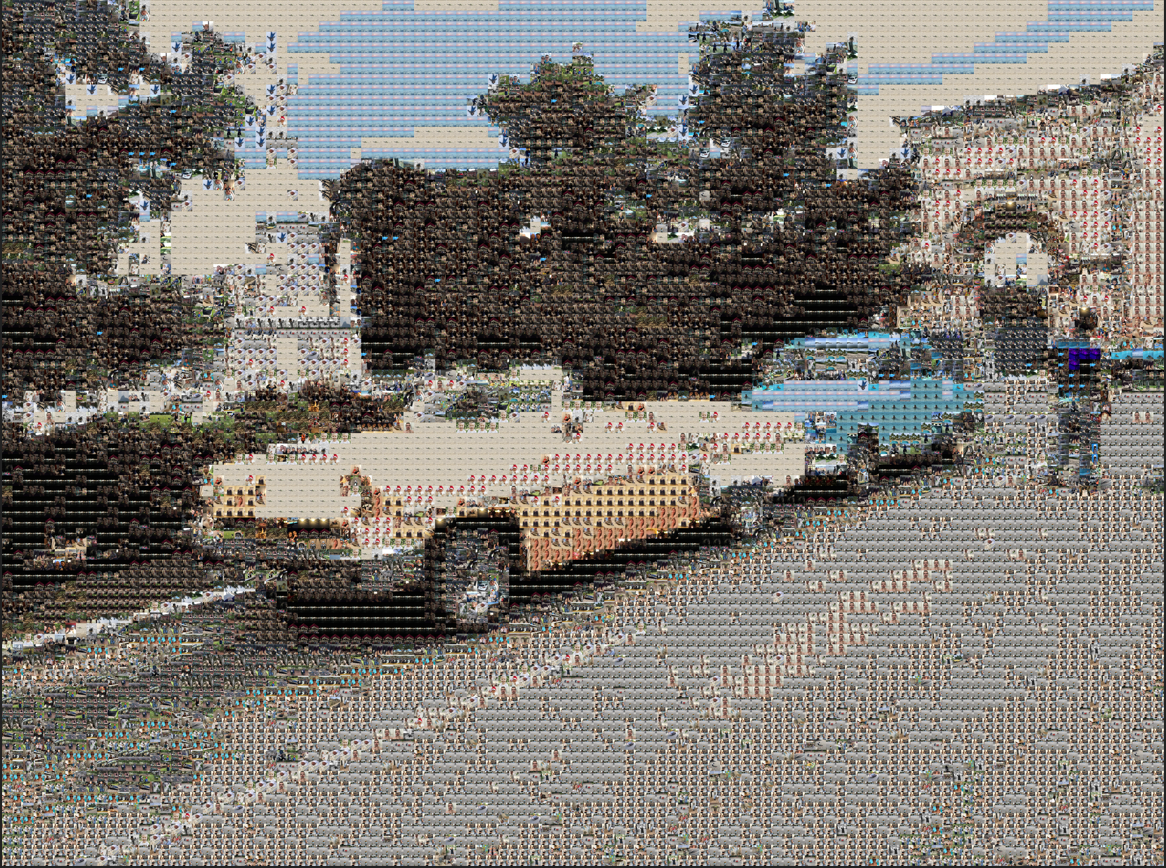